In [26]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
import torch.nn as nn
from random import random
from torch import Tensor
from einops.layers.torch import Rearrange
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Compose as TorchCompose

In [13]:
to_tensor = [Resize((144, 144)), ToTensor()]

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

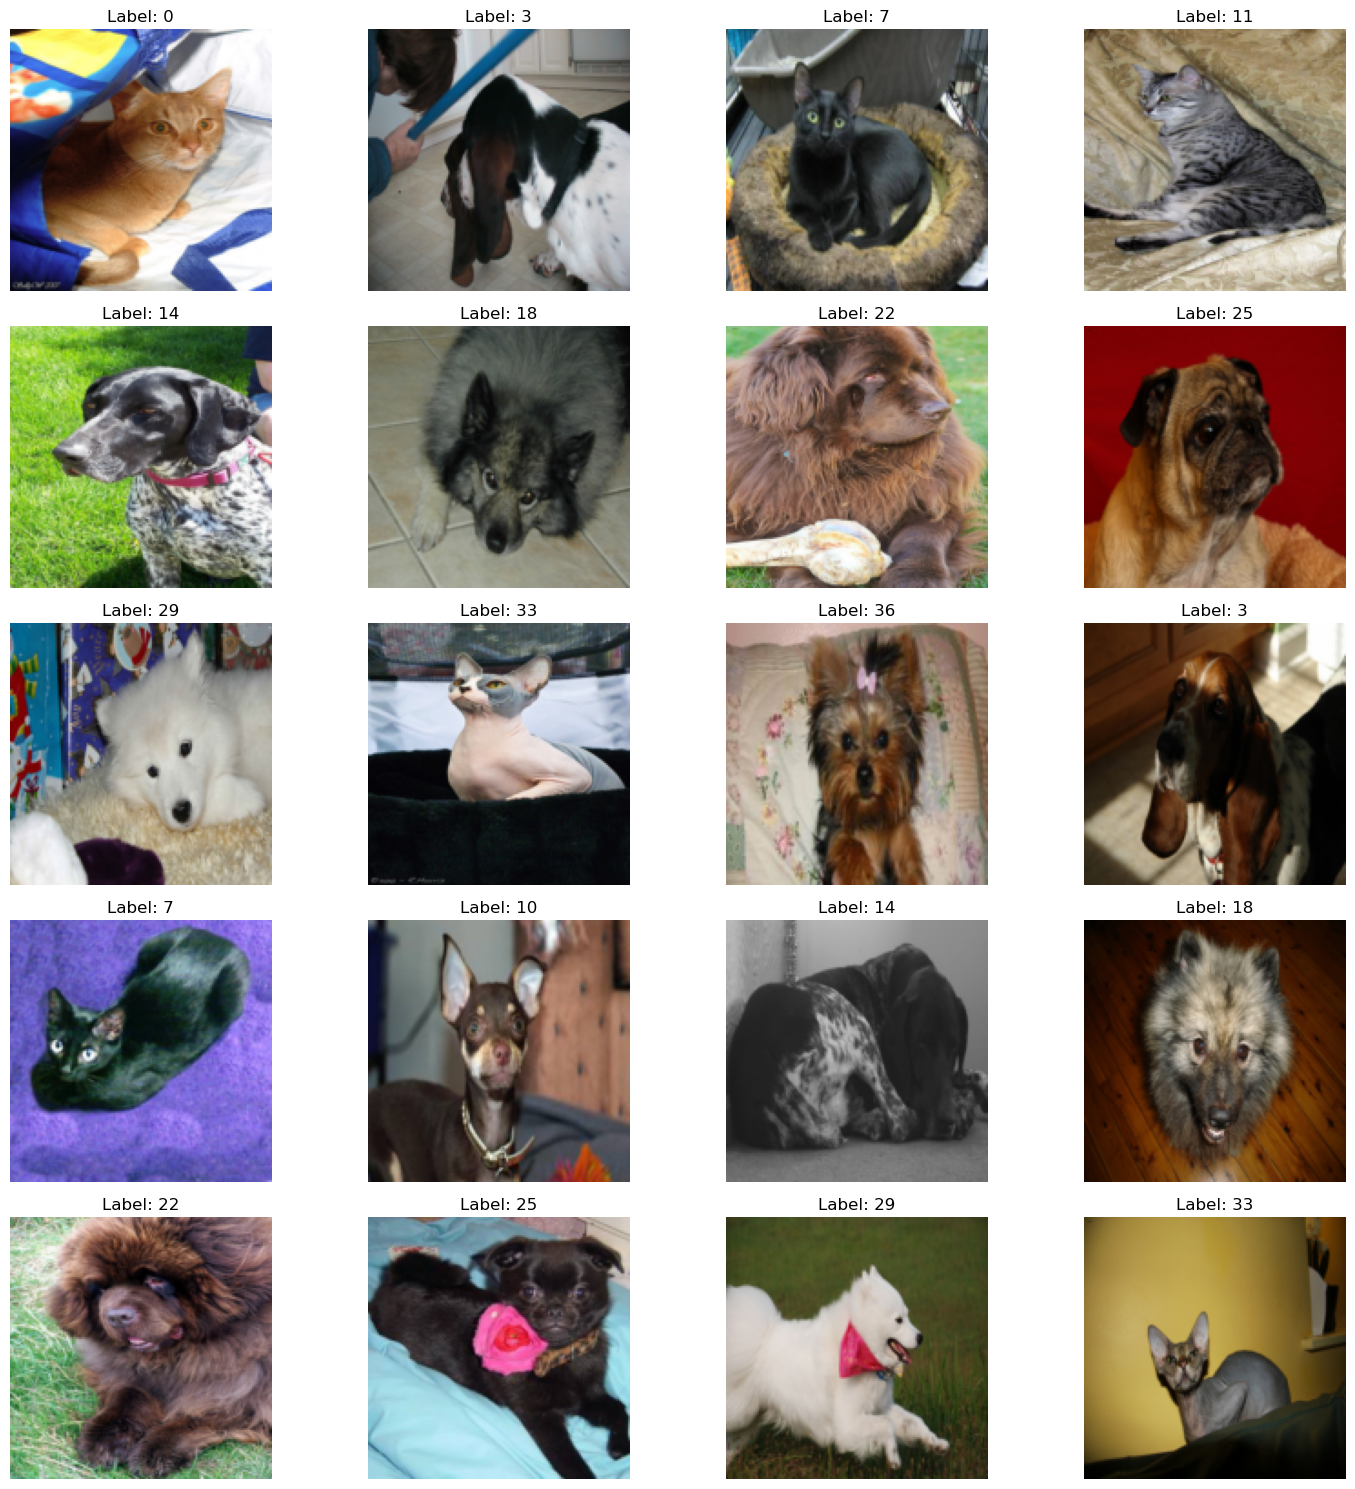

In [21]:
def show_images(dataset, num_samples=20, cols=4, title=None):
    plt.figure(figsize=(15, 15))
    rows = (num_samples + cols - 1) // cols
    indices = [i * len(dataset) // num_samples for i in range(num_samples)]
    
    for idx, i in enumerate(indices):
        if i < len(dataset):
            img, label = dataset[i]
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(to_pil_image(img))
            plt.axis('off')
            plt.title(f'Label: {label}')
    
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

dataset = OxfordIIITPet(root=".", download=True, transform=TorchCompose(to_tensor))
show_images(dataset)

In [39]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=8, emb_size=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Sequential(Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x)
        return x

sample_img = torch.unsqueeze(dataset[0][0], dim=0)
print(f"initial shape: {sample_img.shape}")
patch_embedding = PatchEmbedding()(sample_img)
print(f"patch embedding shape: {patch_embedding.shape}")

initial shape: torch.Size([1, 3, 144, 144])
patch embedding shape: torch.Size([1, 324, 128])


In [45]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=128, num_heads=8, dropout=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        
        self.wq = nn.Linear(emb_size, emb_size)
        self.wk = nn.Linear(emb_size, emb_size)
        self.wv = nn.Linear(emb_size, emb_size)
        self.out = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        batch_size, seq_len, _ = x.shape
        
        q = self.wq(x) # (B, seq_len, emb_size)
        k = self.wk(x)
        v = self.wv(x)

        q = q.reshape(batch_size, seq_len, self.num_heads, self.head_dim) # (B, seq_len, num_heads, head_dim)
        k = k.reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        
        q = q.transpose(1, 2) # (B, num_heads, seq_len, head_dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5) # (B, num_heads, seq_len, seq_len)
        attn_probs = attn_scores.softmax(dim=-1)
        attn_probs = self.dropout(attn_probs)
        
        attn_output = attn_probs @ v # (B, num_heads, seq_len, head_dim)
        
        attn_output = attn_output.transpose(1, 2) # (B, seq_len, num_heads, head_dim)
        attn_output = attn_output.reshape(batch_size, seq_len, self.emb_size)
        
        output = self.out(attn_output)
        return output
    
    MultiHeadAttention(emb_size=128, num_heads=8, dropout=0)(torch.randn(1, 5, 128)).shape

In [47]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

ff = FeedForward(dim=128, hidden_dim=256, dropout=0.1)

In [48]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

residual = Residual(MultiHeadAttention(emb_size=128, num_heads=4, dropout=0.))

In [53]:
class ViT(nn.Module):
    def __init__(self,
                ch = 3,
                img_size = 224,
                patch_size = 16,
                emb_size = 32,
                n_layers = 12,
                out_dim = 37,
                dropout = 0.1,
                heads = 2
    ):
        super().__init__()
        self.channels = ch
        self.h = img_size
        self.w = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        self.patch_embed = PatchEmbedding(in_channels=ch, patch_size=patch_size, emb_size=emb_size)
        self.num_patches = (img_size // patch_size) ** 2

        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.num_patches, emb_size))
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))

        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(emb_size, MultiHeadAttention(emb_size, heads, dropout))),
                Residual(PreNorm(emb_size, FeedForward(emb_size, emb_size, dropout)))
            ]))

        self.mlp_head = nn.Sequential(nn.LayerNorm(emb_size), nn.Linear(emb_size, out_dim))
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.patch_embed(x)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, "1 1 d -> b 1 d", b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed[:, :(n + 1)]

        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)

        x = self.mlp_head(x[:, 0, :])
        return x

vit = ViT()

In [ ]:
from torch.utils.data import DataLoader
from einops import repeat
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = OxfordIIITPet(root=".", split="trainval", target_types="category", transform=transform, download=True)
val_dataset = OxfordIIITPet(root=".", split="test", target_types="category", transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

vit = ViT(
    ch=3,
    img_size=144,
    patch_size=8,
    emb_size=128,
    n_layers=6,
    out_dim=37,
    dropout=0.1,
    heads=8
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)

for epoch in range(20):
    vit.train()
    train_loss = 0
    train_correct = 0
    
    for images, labels in tqdm.tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
    
    vit.eval()
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vit(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
    
    print(f"epoch {epoch+1}: train_loss={train_loss/len(train_loader):.3f}, train_acc={100*train_correct/len(train_dataset):.1f}%, val_loss={val_loss/len(val_loader):.3f}, val_acc={100*val_correct/len(val_dataset):.1f}%")

torch.save(vit.state_dict(), 'vit_model.pth')
print("model saved")

100%|██████████| 115/115 [03:08<00:00,  1.64s/it]


epoch 1: train_loss=3.650, train_acc=3.5%, val_loss=3.632, val_acc=3.8%


100%|██████████| 115/115 [03:06<00:00,  1.62s/it]


epoch 2: train_loss=3.541, train_acc=6.0%, val_loss=3.512, val_acc=6.6%


100%|██████████| 115/115 [03:09<00:00,  1.65s/it]


epoch 3: train_loss=3.385, train_acc=9.0%, val_loss=3.403, val_acc=7.8%


100%|██████████| 115/115 [03:04<00:00,  1.60s/it]


epoch 4: train_loss=3.254, train_acc=10.5%, val_loss=3.353, val_acc=9.9%


100%|██████████| 115/115 [06:29<00:00,  3.39s/it]


epoch 5: train_loss=3.130, train_acc=13.1%, val_loss=3.249, val_acc=11.0%


 77%|███████▋  | 88/115 [05:35<02:03,  4.57s/it]